## Семинар 2 "Распознавание рукописных цифр"

ФИО: Богатенкова Анастасия Олеговна

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [3]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

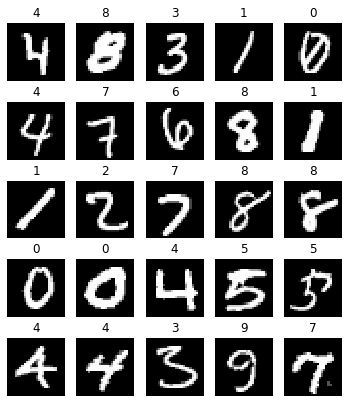

In [4]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [5]:
activation = Sigmoid()

layers = [Linear(784, 100), activation,
          Linear(100, 100), activation,
          Linear(100, 10)]

nn = NeuralNetwork(layers) 

#Linear, Sigmoid, NLLLoss, NeuralNetwork

In [6]:
criterion = NLLLoss()

N = 0
all_losses = []
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy() 

    output = nn.forward(X)
    loss = criterion.forward(output, y)
    dLdy = criterion.backward()    

    all_losses.append(loss)

    nn.backward(dLdy)

    nn.step(0.1)

    N += 1
    if N >= 1000:
        break

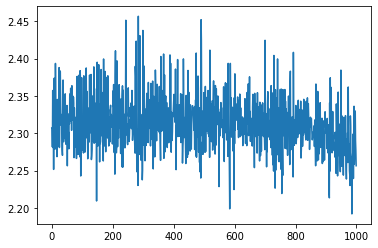

In [7]:
plt.plot(np.array(all_losses))

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [8]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, x):
        self.x = x
        return np.maximum(x, 0)

    def backward(self, dLdy):    
        return dLdy * (self.x > 0)

    def step(self, learning_rate):
        pass

In [9]:
s = ReLU()
s.forward(np.array([[1, -2]]))
s.backward(np.array([[1, -2], [1, 0]]))

array([[1, 0],
       [1, 0]])

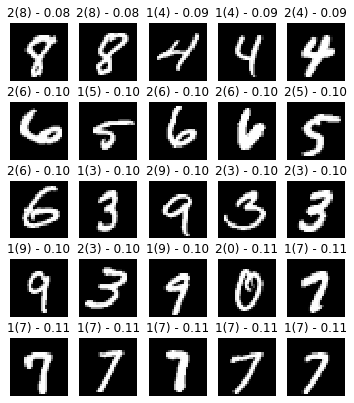

In [10]:
for X, y in test_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy() 

    predictions = nn.forward(X)

    predictions = np.exp(predictions)
    predictions = predictions / np.sum(predictions, axis =- 1).reshape(-1, 1)

    prob = predictions[np.arange(y.shape[0]), y]

    #ind = np.where(prob < 0.7)
    ind = np.argsort(prob)[:25]

    plt.figure(figsize=(6, 7))
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[ind[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.title("%d(%d) - %.2f" % (np.argmax(predictions[ind[i], :]), y[ind[i]], prob[ind[i]]))
        plt.axis('off')    

    break

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [11]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = nn.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

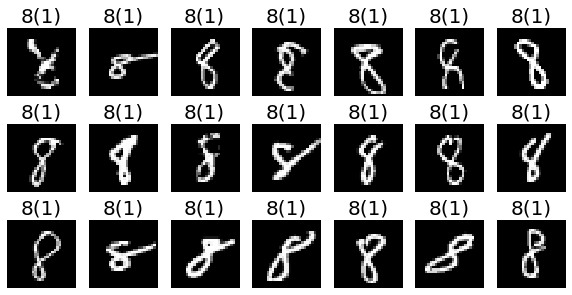

In [12]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

$ \frac{d}{dx}tanh(x) = 1 - (tanh(x)) ^ 2 $

In [13]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.t = np.tanh(X)
        return self.t
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (1 - self.t ** 2) * dLdy
    
    def step(self, learning_rate):
        pass

In [14]:
def compute_losses(activation):
    layers = [Linear(784, 100), activation,
              Linear(100, 100), activation,
              Linear(100, 10)]
    nn = NeuralNetwork(layers)
    criterion = NLLLoss()
    N = 0
    all_losses = []
    for X, y in train_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy() ### Converts torch.Tensor to numpy array
        y = y.numpy() 
        output = nn.forward(X)
        loss = criterion.forward(output, y)
        dLdy = criterion.backward()    
        all_losses.append(loss)
        nn.backward(dLdy)
        nn.step(0.1)
        N += 1
        if N >= 1000:
            break
    return all_losses

In [15]:
act = Tanh()

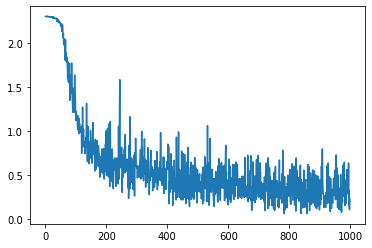

In [16]:
plt.plot(np.array(compute_losses(act)))

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=rotate#torchvision.transforms.functional.rotate

In [17]:
def train(network, epochs, learning_rate, train_loader, test_loader):
    loss = NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [18]:
def different_transform(new_transform=None):
    transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
    train_dataset = MNIST('.', train=True, transform=transform)
    test_dataset = MNIST('.', train=False, transform=transform)
    
    if new_transform:
        new_train_dataset = MNIST('.', train=True, download=True, transform=new_transform)
        train_dataset = train_dataset + new_train_dataset

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
    return train_loader, test_loader

rotations (-15, 15)

In [19]:
transform = transforms.Compose([
                        transforms.RandomAffine(15),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                            ])
tr_loader, ts_loader = different_transform(transform)
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train(network, 10, 0.01, tr_loader, ts_loader)

random shifts

In [20]:
transform = transforms.Compose([
                            transforms.RandomAffine(0, (0.1, 0.1)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,)),
                        ])
tr_loader, ts_loader = different_transform(transform)
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
tr_sh, ts_sh, tr_ac_sh, ts_ac_sh = train(network, 10, 0.01, tr_loader, ts_loader)

noise

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
tr_loader, ts_loader = different_transform(transform)
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
tr_n, ts_n, tr_ac_n, ts_ac_n = train(network, 10, 0.01, tr_loader, ts_loader)

all transformations

In [22]:
transform = transforms.Compose([
    transforms.RandomAffine(15, (0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x : x + torch.randn_like(x)),
    transforms.Normalize((0.1307,), (0.3081,))
])
tr_loader, ts_loader = different_transform(transform)
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
tr_all, ts_all, tr_ac_all, ts_ac_all = train(network, 10, 0.01, tr_loader, ts_loader)

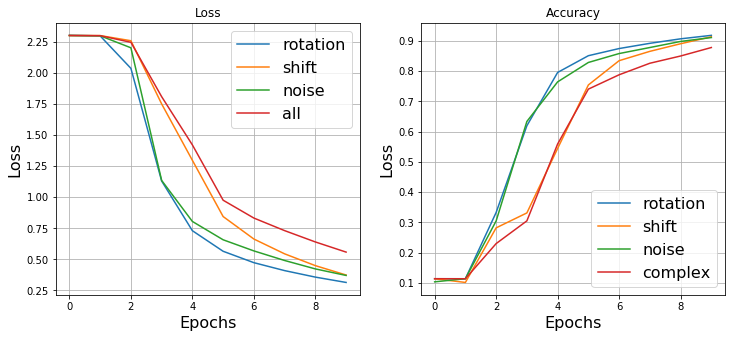

In [23]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_rot, label='rotation')
plt.plot(ts_sh, label='shift')
plt.plot(ts_n, label='noise')
plt.plot(ts_all, label='all')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_rot, label='rotation')
plt.plot(ts_ac_sh, label='shift')
plt.plot(ts_ac_n, label='noise')
plt.plot(ts_ac_all, label='complex')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [24]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

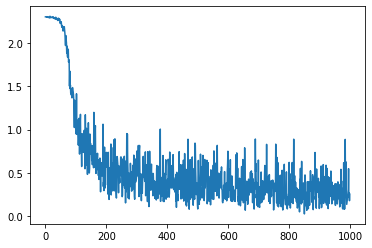

In [25]:
act = ELU()
plt.plot(np.array(compute_losses(act)))

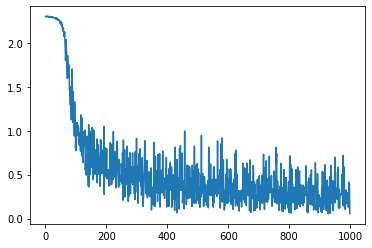

In [26]:
activation = ReLU()
plt.plot(np.array(compute_losses(act)))

In [27]:
tr_loader, ts_loader = different_transform()

In [28]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(),
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
tr_sigm, ts_sigm, tr_ac_sigm, ts_ac_sigm = train(network, 10, 0.01, tr_loader, ts_loader)

In [29]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
tr_relu, ts_relu, tr_ac_relu, ts_ac_relu = train(network, 10, 0.01, tr_loader, ts_loader)

In [30]:
network = NeuralNetwork([
    Linear(784, 100), ELU(),
    Linear(100, 100), ELU(),
    Linear(100, 10)
])
tr_elu, ts_elu, tr_ac_elu, ts_ac_elu = train(network, 10, 0.01, tr_loader, ts_loader)

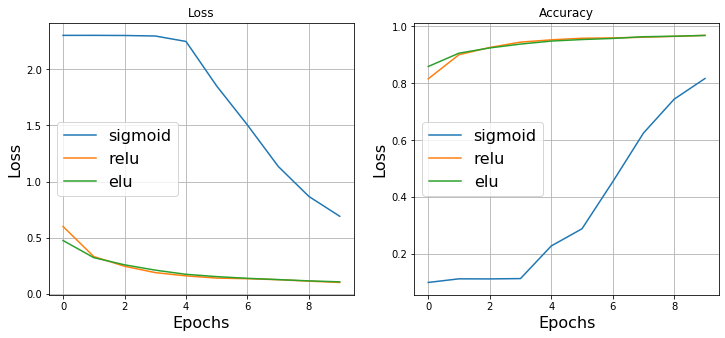

In [31]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_sigm, label='sigmoid')
plt.plot(ts_relu, label='relu')
plt.plot(ts_elu, label='elu')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_sigm, label='sigmoid')
plt.plot(ts_ac_relu, label='relu')
plt.plot(ts_ac_elu, label='elu')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Судя по получившимся графикам:

Небольшие вращения лучше всего влияют на скорость сходимости и на итоговое качество.

Среди нелинейностей, на скорость сходимости лучше влияет sigmoid, однако relu и elu дают лучшее качество